# Capstone Final Report

The data used in this project comes from www.InsideAirbnb.com and can be accessed here: http://data.insideairbnb.com/united-states/ca/los-angeles/2020-02-13/data/listings.csv.gz

In [1]:
import pandas as pd
import numpy as np
from numpy.random import seed
seed(123)
import matplotlib.pyplot as plt
from collections import OrderedDict
%matplotlib inline
from datetime import datetime
import seaborn as sns
import geopandas as gpd
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.model_selection import train_test_split, cross_val_score
import xgboost as xgb
from xgboost import plot_importance
from sklearn.metrics import explained_variance_score, mean_squared_error, r2_score
import time
#from keras import models, layers, optimizers, regularizers
#from keras.utils.vis_utils import model_to_dot
from IPython.display import SVG
from statsmodels.tsa.seasonal import seasonal_decompose

## Extension: I want to import more cities to add data, then random sample and merge DFs as "df"
#df2 = pd.read_csv('listings_Austin.csv')
#df3 = pd.read_csv('listings_Boston.csv')
#df4 = pd.read_csv('listings_Cambridge.csv')
#df5 = pd.read_csv('listings_Chicago.csv')
#df6 = pd.read_csv('listings_Columbus.csv')
#df7 = pd.read_csv('listings_Denver.csv')
#df8 = pd.read_csv('listings_Hawaii.csv')
#df9 = pd.read_csv('listings_Jersey.csv')
#df10 = pd.read_csv('listings_Ashville.csv')
#df11 = pd.read_csv('listings_Miami.csv')
#df12 = pd.read_csv('listings_Nashville.csv')
#df13 = pd.read_csv('listings_NO.csv')
#df14 = pd.read_csv('listings_NYC.csv')
#df15 = pd.read_csv('listings_Oakland.csv')
#df16 = pd.read_csv('listings_Portland.csv')



In [2]:
df1 = pd.read_csv('listings_LA.csv')
print(f"The dataset contains {len(df1)} Airbnb listings")

The dataset contains 38851 Airbnb listings


/anaconda3/lib/python3.7/site-packages/IPython/core/interactiveshell.py:3063: DtypeWarning: Columns (61,62) have mixed types.Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


Getting to know what the raw database looks like:

In [3]:
pd.set_option('display.max_columns', None)
df1.head()

,id,listing_url,scrape_id,last_scraped,name,summary,space,description,experiences_offered,neighborhood_overview,notes,transit,access,interaction,house_rules,thumbnail_url,medium_url,picture_url,xl_picture_url,host_id,host_url,host_name,host_since,host_location,host_about,host_response_time,host_response_rate,host_acceptance_rate,host_is_superhost,host_thumbnail_url,host_picture_url,host_neighbourhood,host_listings_count,host_total_listings_count,host_verifications,host_has_profile_pic,host_identity_verified,street,neighbourhood,neighbourhood_cleansed,neighbourhood_group_cleansed,city,state,zipcode,market,smart_location,country_code,country,latitude,longitude,is_location_exact,property_type,room_type,accommodates,bathrooms,bedrooms,beds,bed_type,amenities,square_feet,price,weekly_price,monthly_price,security_deposit,cleaning_fee,guests_included,extra_people,minimum_nights,maximum_nights,minimum_minimum_nights,maximum_minimum_nights,minimum_maximum_nights,maximum_maximum_nights,minimum_nights_avg_ntm,maximum_nights_avg_ntm,calendar_updated,has_availability,availability_30,availability_60,availability_90,availability_365,calendar_last_scraped,number_of_reviews,number_of_reviews_ltm,first_review,last_review,review_scores_rating,review_scores_accuracy,review_scores_cleanliness,review_scores_checkin,review_scores_communication,review_scores_location,review_scores_value,requires_license,license,jurisdiction_names,instant_bookable,is_business_travel_ready,cancellation_policy,require_guest_profile_picture,require_guest_phone_verification,calculated_host_listings_count,calculated_host_listings_count_entire_homes,calculated_host_listings_count_private_rooms,calculated_host_listings_count_shared_rooms,reviews_per_month
0,109,https://www.airbnb.com/rooms/109,20200213032707,2020-02-13,Amazing bright elegant condo park front *UPGRA...,"*** Unit upgraded with new bamboo flooring, br...","*** Unit upgraded with new bamboo flooring, br...","*** Unit upgraded with new bamboo flooring, br...",none,NaN,NaN,NaN,NaN,NaN,Camelot NEW RESIDENTS’ GENERAL INFORMATION F...,NaN,NaN,https://a0.muscache.com/im/pictures/4321499/1d...,NaN,521,https://www.airbnb.com/users/show/521,Paolo,2008-06-27,"San Francisco, California, United States",Search for me on the Internet with the keyword...,NaN,NaN,NaN,f,https://a0.muscache.com/im/users/521/profile_p...,https://a0.muscache.com/im/users/521/profile_p...,Culver City,1.0,1.0,"['email', 'phone', 'facebook', 'reviews', 'kba']",t,t,"Culver City, CA, United States",Culver City,Culver City,Other Cities,Culver City,CA,90230,Los Angeles,"Culver City, CA",US,United States,33.98209,-118.38494,t,Condominium,Entire home/apt,6,2.0,2.0,3.0,Real Bed,"{TV,""Cable TV"",Internet,Wifi,""Air conditioning...",NaN,$122.00,$904.00,"$2,851.00",$500.00,$240.00,3,$25.00,30,730,30,30,730,730,30.0,730.0,3 days ago,t,0,0,0,0,2020-02-13,2,0,2011-08-15,2016-05-15,80.0,10.0,10.0,6.0,8.0,10.0,8.0,f,NaN,"{""Culver City"","" CA""}",f,f,strict_14_with_grace_period,t,f,1,1,0,0,0.02
1,344,https://www.airbnb.com/rooms/344,20200213032707,2020-02-13,Family perfect;Pool;Near Studios!,This home is perfect for families; aspiring ch...,"Cheerful & comfortable; near studios, amusemen...",This home is perfect for families; aspiring ch...,none,Quiet-yet-close to all the fun in LA! Hollywoo...,"One dog may be on premises, friendly and cared...",Short drive to subway and elevated trains runn...,"Pool, patio and self-contained main house all ...",Host and caretaker may be available throughout...,Host asks that guests refrain from partying lo...,NaN,NaN,https://a0.muscache.com/im/pictures/cc4b724d-d...,NaN,767,https://www.airbnb.com/users/show/767,Melissa,2008-07-11,"Burbank, California, United States","Single mother, CEO and Owner of an internation...",within a day,75%,29%,f,https://a0.muscache.com/im/users/767/profile_p...,https://a0.muscache.com/im/users/767/profile_p...,Burbank,1.0,1.0,"['email', 'phone', 'reviews', 'jumio', 'kba', ...",t,t,"Burbank, CA, United 

For now, I am keeping things simple by just looking at LA listings, but I'm keeping the option open to eventually sample from different cities and then merge them into one df!

# Cleaning the data

In [4]:
df = df1
df.set_index('id', inplace=True) # setting index to listing id as this may help if joining with other dataset
df.columns

Index(['listing_url', 'scrape_id', 'last_scraped', 'name', 'summary', 'space',
       'description', 'experiences_offered', 'neighborhood_overview', 'notes',
       ...
       'instant_bookable', 'is_business_travel_ready', 'cancellation_policy',
       'require_guest_profile_picture', 'require_guest_phone_verification',
       'calculated_host_listings_count',
       'calculated_host_listings_count_entire_homes',
       'calculated_host_listings_count_private_rooms',
       'calculated_host_listings_count_shared_rooms', 'reviews_per_month'],
      dtype='object', length=105)

### Text columns 

In a future extension of this project, I could potentially investigate the text columns using some NLP techniques, sentiment analysis or Word2Vec clustering to potentially help the accuracy of the prediction. But for now, I'm a newbie and this is my first DS project! That being said, I will remove free text columns that I won't be using in this analysis:

In [5]:
cols_to_drop = ['scrape_id', 'last_scraped', 'listing_url','name', 'summary', 'space', 'description', 'neighborhood_overview', 'notes', 'transit', 'access', 'interaction', 'house_rules', 'thumbnail_url', 'medium_url', 'picture_url', 'xl_picture_url', 'host_id', 'host_url', 'host_name', 'host_location', 'host_about', 'host_thumbnail_url', 'host_picture_url', 'host_neighbourhood', 'host_verifications', 'calendar_last_scraped']
df = df.drop(cols_to_drop, axis=1)


In [6]:
len(df.columns)

78

This already removes about 20% of the original columns, further simplifying the database. 

### Dropping NaN heavy columns
I also want to get rid of very sparse columns as they won't do a good job contributing to the model

In [7]:
df.isna()

,experiences_offered,host_since,host_response_time,host_response_rate,host_acceptance_rate,host_is_superhost,host_listings_count,host_total_listings_count,host_has_profile_pic,host_identity_verified,street,neighbourhood,neighbourhood_cleansed,neighbourhood_group_cleansed,city,state,zipcode,market,smart_location,country_code,country,latitude,longitude,is_location_exact,property_type,room_type,accommodates,bathrooms,bedrooms,beds,bed_type,amenities,square_feet,price,weekly_price,monthly_price,security_deposit,cleaning_fee,guests_included,extra_people,minimum_nights,maximum_nights,minimum_minimum_nights,maximum_minimum_nights,minimum_maximum_nights,maximum_maximum_nights,minimum_nights_avg_ntm,maximum_nights_avg_ntm,calendar_updated,has_availability,availability_30,availability_60,availability_90,availability_365,number_of_reviews,number_of_reviews_ltm,first_review,last_review,review_scores_rating,review_scores_accuracy,review_scores_cleanliness,review_scores_checkin,review_scores_communication,review_scores_location,review_scores_value,requires_license,license,jurisdiction_names,instant_bookable,is_business_travel_ready,cancellation_policy,require_guest_profile_picture,require_guest_phone_verification,calculated_host_listings_count,calculated_host_listings_count_entire_homes,calculated_host_listings_count_private_rooms,calculated_host_listings_count_shared_rooms,reviews_per_month
id,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
109,False,False,True,True,True,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,True,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,True,False,False,False,False,False,False,False,False,False,False,False
344,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,True,False,True,True,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,True,True,False,False,False,False,False,False,False,False,False,False
2708,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,True,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,True,False,False,False,False,False,False,False,False,False,False,False
2732,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,True,False,False,False,True,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False
2864,False,False,True,True,True,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,True,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,True,True,True,True,True,True,True,True,True,False,True,True,False,False,False,False,False,False,False,False,False,True
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,.

By inspection, it looks like the following columns have a higher number of NaN values and will not necessarily help our model, so they will be dropped

In [8]:
print(df['license'].isna().sum(), 
      df['square_feet'].isna().sum(),
      df['host_acceptance_rate'].isna().sum(),
      df['jurisdiction_names'].isna().sum(),
      df['weekly_price'].isna().sum(),
      df['monthly_price'].isna().sum(),
      df['neighbourhood_group_cleansed'].isna().sum()
     )

29412 38568 5837 12074 35096 35335 0


In [9]:
df.drop(['license', 'square_feet', 'host_acceptance_rate', 'jurisdiction_names', 
         'weekly_price', 'monthly_price', 'calendar_updated'], axis=1, inplace=True) 

The following columns are highly correlated to the column "host_listings_count" (the first one "host_total_listings_count" being exactly the same except for in 2 columns with NaN as the value), so they will not provide additional information for the prediction. Drop!

In [10]:
df.drop(['host_total_listings_count', 'calculated_host_listings_count', 
         'calculated_host_listings_count_entire_homes', 
         'calculated_host_listings_count_private_rooms', 
         'calculated_host_listings_count_shared_rooms'], axis=1, inplace=True)

There are multiple columns for minimum and maximum night stays, but the two main ones will be used 

In [11]:
sum((df.minimum_nights == df.minimum_minimum_nights) == False)

1840

In [12]:
df.drop(['minimum_minimum_nights', 'maximum_minimum_nights', 'minimum_maximum_nights', 'maximum_maximum_nights', 
         'minimum_nights_avg_ntm', 'maximum_nights_avg_ntm'], axis=1, inplace=True)

A lot of these only have one category, so encoding these won't add much to the model. I will drop a few to clean it up:

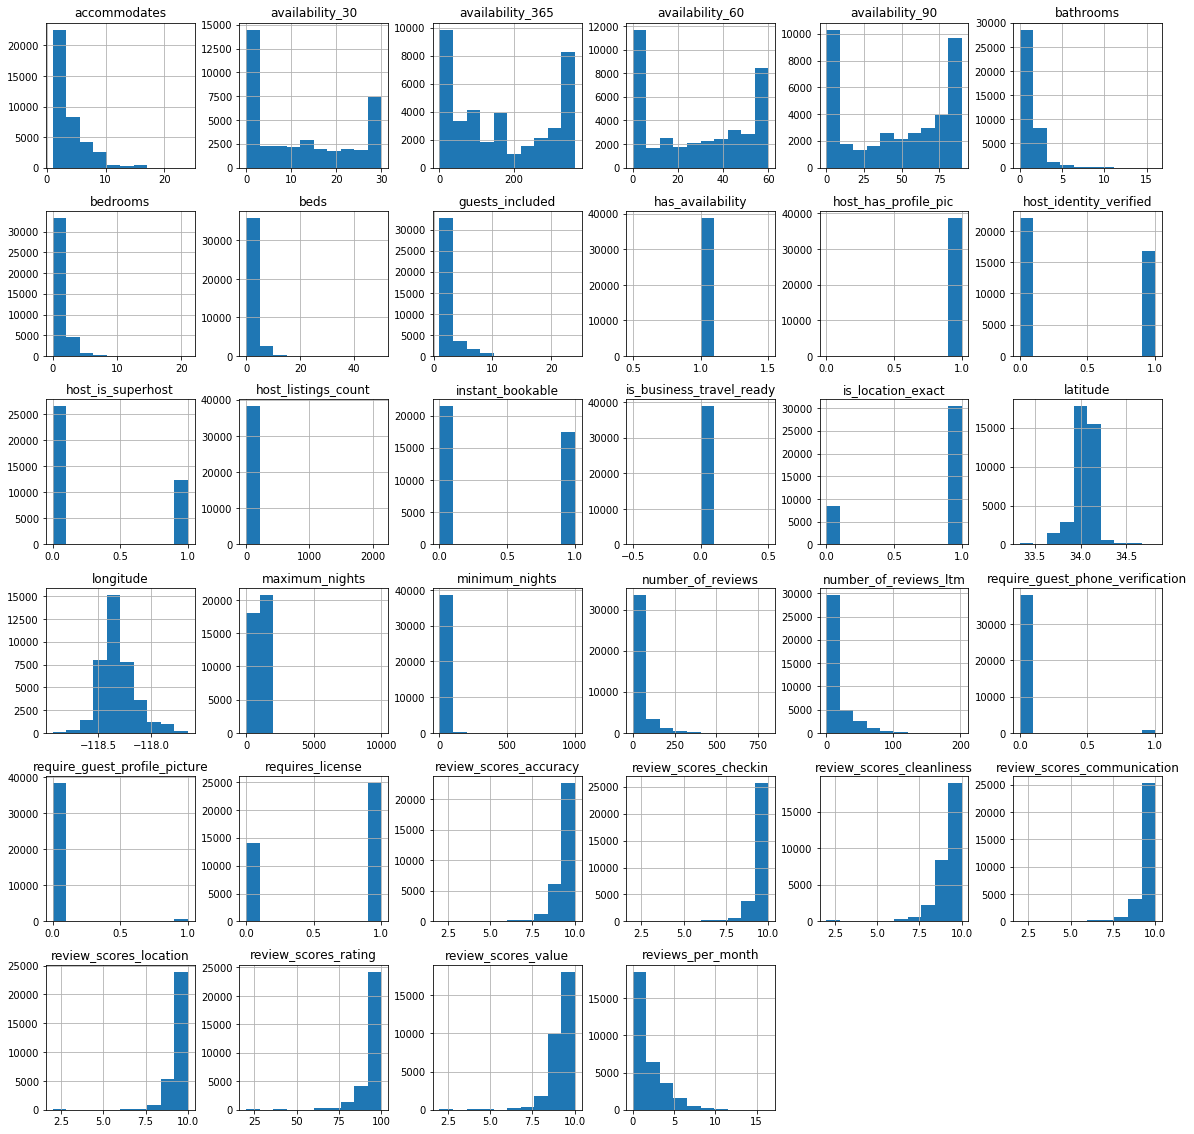

In [13]:
# Replacing f/t with 0/1
df.replace({'f': 0, 't': 1}, inplace=True)

# Plotting the distribution of numerical and boolean categories
df.hist(figsize=(20,20));

In [14]:
df.drop(['has_availability', 'host_has_profile_pic', 'is_business_travel_ready', 'require_guest_phone_verification', 
         'require_guest_profile_picture'], axis=1, inplace=True)

In [15]:
len(df[df.experiences_offered == 'none'])

38851

In [16]:
df.drop('experiences_offered', axis=1, inplace=True)

### Location

We have multiple columns related to the location of the listings. We may be able to clear some of this redundant information, as well as save the latitude/longitude for future reference. I am also keeping city/state keeping in mind that I would want to extend this to multiple cities and it could be useful to have categorical location columns.

In [17]:
precise_location = df[['latitude', 'longitude']]

In [18]:
df.drop(['zipcode', 'street', 'city', 'state', 'market','neighbourhood', 
         'smart_location', 'country_code', 'country', 'is_location_exact'], axis=1, inplace=True)

In [19]:
df.neighbourhood_group_cleansed.value_counts()

City of Los Angeles     22890
Other Cities            13093
Unincorporated Areas     2868
Name: neighbourhood_group_cleansed, dtype: int64

This column is a little too general if we want to get granular about location, and it will be highly correlated to the neighbourhood_cleansed attribute, so I will drop. 

In [20]:
df.drop('neighbourhood_group_cleansed', axis=1, inplace=True)

In [21]:
df.columns

Index(['host_since', 'host_response_time', 'host_response_rate',
       'host_is_superhost', 'host_listings_count', 'host_identity_verified',
       'neighbourhood_cleansed', 'latitude', 'longitude', 'property_type',
       'room_type', 'accommodates', 'bathrooms', 'bedrooms', 'beds',
       'bed_type', 'amenities', 'price', 'security_deposit', 'cleaning_fee',
       'guests_included', 'extra_people', 'minimum_nights', 'maximum_nights',
       'availability_30', 'availability_60', 'availability_90',
       'availability_365', 'number_of_reviews', 'number_of_reviews_ltm',
       'first_review', 'last_review', 'review_scores_rating',
       'review_scores_accuracy', 'review_scores_cleanliness',
       'review_scores_checkin', 'review_scores_communication',
       'review_scores_location', 'review_scores_value', 'requires_license',
       'instant_bookable', 'cancellation_policy', 'reviews_per_month'],
      dtype='object')

### Column Descriptions

'listing_url', 
'host_since', 
'host_response_time', 
'host_response_rate',
'host_is_superhost', 
'host_listings_count', 
'host_identity_verified',
'street', 
'neighbourhood', 
'neighbourhood_cleansed',
'neighbourhood_group_cleansed', 
'city', 
'state', 
'zipcode', 
'market',
'smart_location', 
'country_code', 
'country', 
'latitude', 
'longitude',
'is_location_exact', 
'property_type', 
'room_type', 
'accommodates',
'bathrooms', 
'bedrooms', 
'beds', 
'bed_type', 
'amenities', 
'price',
'security_deposit', 
'cleaning_fee', 
'guests_included', 
'extra_people',
'minimum_nights', 
'maximum_nights', 
'availability_30',
'availability_60', 
'availability_90', 
'availability_365',
'number_of_reviews', 
'number_of_reviews_ltm', 
'first_review',
'last_review', 
'review_scores_rating', 
'review_scores_accuracy',
'review_scores_cleanliness', 
'review_scores_checkin',
'review_scores_communication', 
'review_scores_location',
'review_scores_value', 
'requires_license', 
'instant_bookable',
'cancellation_policy', 
'reviews_per_month'

### Our target to predict: Price
As we will want to predict the nightly price of the listing with accuracy, I will convert the nightly "Price" column into an integer value, as right now it is a string with symbol "$" in front.


In [22]:
df.price.head()

id
109     $122.00
344     $168.00
2708     $79.00
2732    $140.00
2864     $80.00
Name: price, dtype: object

In [23]:
##change prices to float values
df.price = df.price.str[1:-3]
df.price = df.price.str.replace(",", "")
df.price = df.price.astype('int64')
df.price.head()

id
109     122
344     168
2708     79
2732    140
2864     80
Name: price, dtype: int64

Inspecting min and max values of our target to get a sense of our range:

In [24]:
df.price.max()

22000

This seems like a very high nightly price, so it may be worth investigating to see if this is an extreme outlier to the dataset.

In [25]:
#find listing with max price
df[df.price == 22000]

,host_since,host_response_time,host_response_rate,host_is_superhost,host_listings_count,host_identity_verified,neighbourhood_cleansed,latitude,longitude,property_type,room_type,accommodates,bathrooms,bedrooms,beds,bed_type,amenities,price,security_deposit,cleaning_fee,guests_included,extra_people,minimum_nights,maximum_nights,availability_30,availability_60,availability_90,availability_365,number_of_reviews,number_of_reviews_ltm,first_review,last_review,review_scores_rating,review_scores_accuracy,review_scores_cleanliness,review_scores_checkin,review_scores_communication,review_scores_location,review_scores_value,requires_license,instant_bookable,cancellation_policy,reviews_per_month
id,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
20470360,2014-11-07,a few days or more,30%,0.0,42.0,1.0,Hollywood Hills West,34.10198,-118.36703,Villa,Entire home/apt,18,10.5,8.0,10.0,Real Bed,"{TV,Wifi,""Air conditioning"",Pool,Kitchen,""Free...",22000,"$150,000.00",NaN,18,$0.00,1,1125,28,58,88,363,0,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1,0,luxury_moderate,NaN
27781015,2014-11-07,a few days or more,30%,0.0,42.0,1.0,Beverly Hills,34.09396,-118.41466,Villa,Entire home/apt,14,6.5,7.0,5.0,Real Bed,"{TV,Wifi,""Air conditioning"",Kitchen,""Free park...",22000,"$100,000.00",NaN,14,$0.00,1,1125,29,59,89,364,0,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1,0,luxury_moderate,NaN


Afer using the listing URLs to search these, these are verified prices (holy crap!) and are part of the "Luxury Retreats" section of AirBnB I wasn't aware existed... Check them out, they are gorgeous!

In [26]:
df.price.min()

0

I find it really weird that there would be listings with a price of $0. This could be an entry mistake...

In [27]:
#find the listing with $0/night price
df[df.price == 0]

,host_since,host_response_time,host_response_rate,host_is_superhost,host_listings_count,host_identity_verified,neighbourhood_cleansed,latitude,longitude,property_type,room_type,accommodates,bathrooms,bedrooms,beds,bed_type,amenities,price,security_deposit,cleaning_fee,guests_included,extra_people,minimum_nights,maximum_nights,availability_30,availability_60,availability_90,availability_365,number_of_reviews,number_of_reviews_ltm,first_review,last_review,review_scores_rating,review_scores_accuracy,review_scores_cleanliness,review_scores_checkin,review_scores_communication,review_scores_location,review_scores_value,requires_license,instant_bookable,cancellation_policy,reviews_per_month
id,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
18506601,2013-01-22,within an hour,100%,1.0,3.0,1.0,Long Beach,33.82912,-118.20102,House,Private room,2,1.0,1.0,1.0,Real Bed,"{TV,""Cable TV"",Internet,Wifi,""Air conditioning...",0,$200.00,$50.00,2,$100.00,1,1125,2,32,62,337,70,34,2017-07-09,2020-02-10,98.0,10.0,10.0,10.0,10.0,10.0,10.0,0,0,moderate,2.21
18562002,2017-05-04,NaN,NaN,0.0,1.0,1.0,Culver City,33.99522,-118.43324,House,Entire home/apt,7,2.0,3.0,3.0,Real Bed,"{TV,""Cable TV"",Internet,Wifi,""Air conditioning...",0,$400.00,$100.00,6,$10.00,1,1125,0,0,0,0,16,0,2017-05-05,2017-11-26,94.0,9.0,9.0,10.0,9.0,10.0,9.0,0,0,strict_14_with_grace_period,0.47
21099870,2017-09-25,within an hour,100%,1.0,2.0,0.0,Harbor Gateway,33.86413,-118.29326,House,Private room,2,1.0,1.0,1.0,Real Bed,"{TV,""Cable TV"",Wifi,""Free parking on premises""...",0,$100.00,$20.00,1,$20.00,1,1125,0,1,13,288,32,12,2017-10-15,2019-09-15,99.0,10.0,10.0,10.0,10.0,10.0,10.0,1,0,strict_14_with_grace_period,1.13
21187671,2015-04-18,within an hour,100%,0.0,10.0,0.0,Van Nuys,34.19718,-118.44036,Apartment,Entire home/apt,4,1.0,1.0,1.0,Real Bed,"{TV,""Cable TV"",Wifi,""Air conditioning"",Kitchen...",0,$0.00,$100.00,1,$0.00,30,150,0,0,0,164,0,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1,1,strict_14_with_grace_period,NaN
29421142,2016-12-03,within an hour,100%,1.0,3.0,0.0,North Hollywood,34.16589,-118.35716,House,Entire home/apt,7,1.5,2.0,3.0,Real Bed,"{TV,""Cable TV"",Internet,Wifi,""Air conditioning...",0,$250.00,$145.00,4,$15.00,30,120,0,12,41,41,8,7,2019-01-03,2020-02-01,100.0,10.0,10.0,10.0,10.0,10.0,10.0,1,0,moderate,0.59


After searching the host URLs for each of these 5 listings, it turns out there is a nonzero price for all. Because there are only 5 of them, it was easy to verify the actual prices. If there were more, I would not have known why!! I know I have plenty of data, but for practice with indexing and using .loc to access entries, I'm going to replace these with the verified prices as of 03-13-20.

In [28]:
df.loc[df.index == 18506601, 'price'] = 70.0
df.loc[df.index == 18506601, 'price']

id
18506601    70.0
Name: price, dtype: float64

In [29]:
df.loc[df.index == 18562002, 'price'] = 189.0
df.loc[df.index == 21099870, 'price'] = 57.0
df.loc[df.index == 21187671, 'price'] = 95.0
df.loc[df.index == 29421142, 'price'] = 150.0

In [30]:
#check
len(df[df.price == 0])

0

#### Security Deposit, Cleaning Fee, Extra People
We will want to do the same thing for the security deposit, cleaning fee and extra people columns, but these ones have a lot of NaN values, which should just be zeros.

In [31]:
df.security_deposit.isna().sum()

9270

In [32]:
df.security_deposit = df.security_deposit.str[1:-3]
df.security_deposit = df.security_deposit.str.replace(",", "")
df.security_deposit.fillna(0, inplace=True)
df.security_deposit = df.security_deposit.astype('int64')
df.security_deposit.head()

id
109     500
344       0
2708    450
2732      0
2864    100
Name: security_deposit, dtype: int64

In [33]:
df.cleaning_fee = df.cleaning_fee.str[1:-3]
df.cleaning_fee = df.cleaning_fee.str.replace(",", "")
df.cleaning_fee.fillna(0, inplace=True)
df.cleaning_fee = df.cleaning_fee.astype('int64')
df.cleaning_fee.head()

id
109     240
344     100
2708     84
2732    100
2864     75
Name: cleaning_fee, dtype: int64

In [34]:
df.extra_people = df.extra_people.str[1:-3]
df.extra_people = df.extra_people.str.replace(",", "")
df.extra_people.fillna(0, inplace=True)
df.extra_people = df.extra_people.astype('int64')
df.extra_people.head()

id
109     25
344      0
2708     0
2732     0
2864    25
Name: extra_people, dtype: int64

### Exploring Bedrooms and Property Information

/anaconda3/lib/python3.7/site-packages/numpy/lib/histograms.py:839: RuntimeWarning: invalid value encountered in greater_equal
  keep = (tmp_a >= first_edge)
/anaconda3/lib/python3.7/site-packages/numpy/lib/histograms.py:840: RuntimeWarning: invalid value encountered in less_equal
  keep &= (tmp_a <= last_edge)


(-1.05, 10)

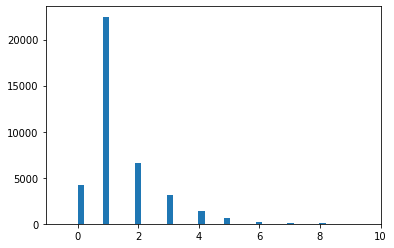

In [35]:
plt.hist(df.bedrooms, bins=100)
plt.xlim(right=10)

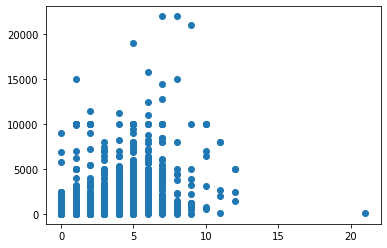

In [36]:
plt.scatter(df.bedrooms, df.price)

Looks like we have an outlier here on number of bedrooms. Let's inspect:

In [37]:
df[df.bedrooms >=20]

,host_since,host_response_time,host_response_rate,host_is_superhost,host_listings_count,host_identity_verified,neighbourhood_cleansed,latitude,longitude,property_type,room_type,accommodates,bathrooms,bedrooms,beds,bed_type,amenities,price,security_deposit,cleaning_fee,guests_included,extra_people,minimum_nights,maximum_nights,availability_30,availability_60,availability_90,availability_365,number_of_reviews,number_of_reviews_ltm,first_review,last_review,review_scores_rating,review_scores_accuracy,review_scores_cleanliness,review_scores_checkin,review_scores_communication,review_scores_location,review_scores_value,requires_license,instant_bookable,cancellation_policy,reviews_per_month
id,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
39395189,2019-10-15,within an hour,80%,0.0,0.0,0.0,Hollywood,34.10182,-118.33476,Hotel,Private room,2,0.0,21.0,1.0,Real Bed,"{TV,Wifi,Heating,""Smoke detector"",Shampoo,""Loc...",100.0,0,0,1,0,1,21,29,59,89,364,0,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1,1,flexible,NaN


So this is a hotel listing, where they have entered the total number of hotel rooms as "bedrooms" but really it should be 1.0. How are other hotels listed?

In [38]:
df[df.property_type=='Hotel']

,host_since,host_response_time,host_response_rate,host_is_superhost,host_listings_count,host_identity_verified,neighbourhood_cleansed,latitude,longitude,property_type,room_type,accommodates,bathrooms,bedrooms,beds,bed_type,amenities,price,security_deposit,cleaning_fee,guests_included,extra_people,minimum_nights,maximum_nights,availability_30,availability_60,availability_90,availability_365,number_of_reviews,number_of_reviews_ltm,first_review,last_review,review_scores_rating,review_scores_accuracy,review_scores_cleanliness,review_scores_checkin,review_scores_communication,review_scores_location,review_scores_value,requires_license,instant_bookable,cancellation_policy,reviews_per_month
id,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
11374,2009-09-29,within an hour,100%,1.0,2.0,0.0,Gardena,33.90348,-118.29269,Hotel,Private room,2,1.0,1.0,1.0,Real Bed,"{TV,""Cable TV"",Wifi,""Air conditioning"",""Wheelc...",80.0,100,0,1,10,1,7,29,59,89,364,24,11,2011-04-14,2020-02-11,90.0,9.0,9.0,10.0,9.0,8.0,9.0,1,1,flexible,0.22
44511,2010-08-08,within a few hours,100%,0.0,8.0,1.0,Lynwood,33.91942,-118.20913,Hotel,Private room,2,1.0,1.0,1.0,Real Bed,"{TV,Wifi,""Air conditioning"",""Free parking on p...",58.0,0,0,2,0,1,25,28,58,88,178,207,17,2011-03-07,2020-01-18,89.0,9.0,9.0,10.0,9.0,9.0,9.0,0,0,flexible,1.90
46699,2010-08-08,within a few hours,100%,0.0,8.0,1.0,Lynwood,33.91942,-118.20913,Hotel,Private room,2,1.0,1.0,1.0,Real Bed,"{TV,""Cable TV"",Wifi,""Air conditioning"",""Free p...",58.0,0,0,1,0,1,25,29,59,89,179,177,29,2011-06-22,2020-01-27,92.0,9.0,9.0,10.0,10.0,9.0,9.0,0,0,flexible,1.68
84636,2010-08-08,within a few hours,100%,0.0,8.0,1.0,Lynwood,33.91942,-118.20913,Hotel,Private room,2,1.0,1.0,1.0,Real Bed,"{TV,Wifi,""Air conditioning"",""Free parking on p...",58.0,0,0,1,0,1,25,26,56,86,176,210,27,2011-05-26,2020-02-02,90.0,10.0,9.0,10.0,10.0,9.0,10.0,0,0,flexible,1.98
97000,2010-08-08,within a few hours,100%,0.0,8.0,1.0,Lynwood,33.91942,-118.20913,Hotel,Private room,4,1.0,1.0,2.0,Real Bed,"{TV,""Cable TV"",Wifi,""Air conditioning"",""Free p...",75.0,0,0,1,0,1,25,27,57,87,177,75,10,2011-08-22,2020-01-01,83.0,9.0,8.0,9.0,9.0,7.0,8.0,0,0,flexible,0.73
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
42066070,2019-08-02,NaN,NaN,0.0,6.0,0.0,Downtown,34.05069,-118.25596,Hotel,Private room,2,1.0,1.0,1.0,Real Bed,"{TV,Internet,Wifi,""Air conditioning"",""Pets all...",10000.0,0,0,1,0,1,5,24,54,81,343,0,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1,1,flexible,NaN
42066095,2019-08-02,NaN,NaN,0.0,6.0,0.0,Downtown,34.05049,-118.25772,Hotel,Private room,2,1.0,1.0,1.0,Real Bed,"{TV,Internet,""Air conditioning"",""Pets allowed""...",10000.0,0,0,1,0,1,1125,30,60,90,365,0,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1,1,flexible,NaN
42066113,2019-08-02,NaN,NaN,0.0,6.0,0.0,Downtown,34.04998,-118.25583,Hotel,Private room,2,1.0,1.0,1.0,Real Bed,"{Internet,Wifi,""Air conditioning"",""Pets allowe...",10000.0,0,0,1,0,1,1125,30,60,90,365,0,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1,1,flexible,NaN


Just going to fix this listing since we can see how the hotels are supposed to be listed.

In [39]:
df.loc[df.index == 39395189, 'bedrooms'] = 1.0
len(df[df.bedrooms >=15])

0

In [40]:
len(df.columns) #Check how many columns we have reduced to

43

#### Property Type

We have a lot of property types that don't have very many values in them, and categories that could be grouped together as a type of house, apartment, or "other" more unique places to stay.

In [41]:
df.property_type.value_counts()

House                     13745
Apartment                 12944
Condominium                2416
Guesthouse                 2153
Guest suite                1501
Townhouse                  1219
Bungalow                   1016
Villa                       981
Loft                        748
Serviced apartment          515
Boutique hotel              271
Hostel                      182
Cottage                     178
Aparthotel                  168
Camper/RV                   154
Bed and breakfast           130
Tiny house                   95
Other                        92
Hotel                        67
Cabin                        63
Farm stay                    34
Earth house                  22
Castle                       21
Boat                         20
Dome house                   17
Campsite                     15
Treehouse                    12
Tent                         10
Barn                         10
Chalet                        9
Dorm                          7
Yurt    

In [42]:
#We can group together the categories that are all classifications of house/apartment
df.property_type.replace({
    'Townhouse': 'House',
    'Bungalow': 'House',
    'Cottage': 'House',
    'Villa': 'House',
    'Tiny house': 'House',
    'Earth house': 'House',
    'Chalet': 'House',
    'Guesthouse' : 'House',
    'Serviced apartment': 'Apartment',
    'Loft': 'Apartment',
    'Aparthotel' : 'Apartment',
    'Condominium' : 'Apartment',
    }, inplace=True)

df.loc[~df.property_type.isin(['House', 'Apartment']), 'property_type'] = 'Other'

In [43]:
df.property_type.value_counts()

House        19418
Apartment    16791
Other         2642
Name: property_type, dtype: int64

#### Bathrooms, Bedrooms, Beds

We will replace missing values with the median value of each. For bed_type, most have a real bed so this won't do much for our model

In [44]:
for col in ['bathrooms', 'bedrooms', 'beds']:
    df[col].fillna(df[col].median(), inplace=True)

In [45]:
df.bed_type.value_counts()

Real Bed         38491
Futon              143
Pull-out Sofa       87
Airbed              73
Couch               57
Name: bed_type, dtype: int64

In [46]:
df.drop('bed_type', axis=1, inplace=True)

#### Reviews!

Many listings haven't had a review written at all. This information should be retained for the ones who have been reviewed, but there are a lot of missing values here. The missing values can mean that they are new listings, or the listings haven't been booked for reasons other than the price not being right (the host doesn't make it available often, being one possible scenario).

In [47]:
print(f"Null values in 'first_review': {round(100*df.first_review.isna().sum()/len(df),1)}%")
print(f"Null values in 'review_scores_rating': {round(100*df.review_scores_rating .isna().sum()/len(df),1)}%")

Null values in 'first_review': 19.8%
Null values in 'review_scores_rating': 21.1%


In [48]:
#What to do with this? Bin reviews and label NaN with "unknown" or something?
df.drop('last_review', axis=1, inplace=True)

#### Cancellation Policy

Most entries fall into 3 main categories here, so we will bin everything into strict, moderate and flexible.

In [49]:
df.cancellation_policy.value_counts()

strict_14_with_grace_period    16579
flexible                       10989
moderate                       10704
super_strict_60                  214
strict                           207
luxury_moderate                  114
super_strict_30                   19
luxury_super_strict_95            18
luxury_no_refund                   7
Name: cancellation_policy, dtype: int64

In [50]:
# Replacing categories
df.cancellation_policy.replace({
    'strict_14_with_grace_period':'strict',
    'super_strict_30': 'strict',
    'super_strict_60': 'strict',
    'strict': 'strict',
    'luxury_moderate': 'moderate',
    'luxury_super_strict_95': 'strict',
    'luxury_no_refund': 'strict'
    }, inplace=True)

In [51]:
df.cancellation_policy.value_counts()

strict      17044
flexible    10989
moderate    10818
Name: cancellation_policy, dtype: int64

#### Availability

There are multiple columns for availablity. We will keep the 90 day one because LA has an ordinance against renting out primary residence for short term stays for more than 120 days. These will also be highly correlated so we are just keeping one.

In [52]:
df.drop(['availability_30', 'availability_60', 'availability_365'], axis=1, inplace=True)

In [53]:
df.drop(['number_of_reviews_ltm', 'reviews_per_month'], axis=1, inplace=True)

#### Host_since

In [54]:
# Converting to datetime
df.host_since = pd.to_datetime(df.host_since) 

# Calculating the number of days
df['host_days_active'] = (datetime(2019, 4, 9) - df.host_since).astype('timedelta64[D]')

# Printing mean and median
print("Mean days as host:", round(df['host_days_active'].mean(),0))
print("Median days as host:", df['host_days_active'].median())

# Replacing null values with the median
df.host_days_active.fillna(df.host_days_active.median(), inplace=True)

Mean days as host: 1229.0
Median days as host: 1216.0


In [55]:
print("Null values:", df.host_response_time.isna().sum())
print(f"Proportion: {round((df.host_response_time.isna().sum()/len(df))*100, 1)}%")

df.host_response_time.fillna("unknown", inplace=True)
df.host_response_time.value_counts(normalize=True)

Null values: 8678
Proportion: 22.3%


within an hour        0.595351
unknown               0.223366
within a few hours    0.099740
within a day          0.062032
a few days or more    0.019510
Name: host_response_time, dtype: float64

#### host_response_rate

In [56]:
# Removing the % sign from the host_response_rate string and converting to an integer
df.host_response_rate = df.host_response_rate.str[:-1].astype('float64')

print("Mean host response rate:", round(df['host_response_rate'].mean(),0))
print("Median host response rate:", df['host_response_rate'].median())
print(f"Proportion of 100% host response rates: {round(((df.host_response_rate == 100.0).sum()/df.host_response_rate.count())*100,1)}%")
# Bin into four categories
df.host_response_rate = pd.cut(df.host_response_rate, bins=[0, 50, 90, 99, 100], labels=['0-49%', '50-89%', '90-99%', '100%'], include_lowest=True)

# Converting to string
df.host_response_rate = df.host_response_rate.astype('str')

# Replace nulls with 'unknown'
df.host_response_rate.replace('nan', 'unknown', inplace=True)

# Category counts
df.host_response_rate.value_counts()

Mean host response rate: 95.0
Median host response rate: 100.0
Proportion of 100% host response rates: 78.9%


100%       23815
unknown     8678
50-89%      2844
90-99%      2459
0-49%       1055
Name: host_response_rate, dtype: int64

In [57]:
df.dropna(subset=['host_since'], inplace=True)

In [58]:

df.drop('amenities',inplace=True, axis=1)

In [59]:
print(df.info())

<class 'pandas.core.frame.DataFrame'>
Int64Index: 38849 entries, 109 to 42254828
Data columns (total 36 columns):
 #   Column                       Non-Null Count  Dtype         
---  ------                       --------------  -----         
 0   host_since                   38849 non-null  datetime64[ns]
 1   host_response_time           38849 non-null  object        
 2   host_response_rate           38849 non-null  object        
 3   host_is_superhost            38849 non-null  float64       
 4   host_listings_count          38849 non-null  float64       
 5   host_identity_verified       38849 non-null  float64       
 6   neighbourhood_cleansed       38849 non-null  object        
 7   latitude                     38849 non-null  float64       
 8   longitude                    38849 non-null  float64       
 9   property_type                38849 non-null  object        
 10  room_type                    38849 non-null  object        
 11  accommodates                 38849 n

In [60]:
for i in df.columns:
    print(i, df[i].isna().sum())

host_since 0
host_response_time 0
host_response_rate 0
host_is_superhost 0
host_listings_count 0
host_identity_verified 0
neighbourhood_cleansed 0
latitude 0
longitude 0
property_type 0
room_type 0
accommodates 0
bathrooms 0
bedrooms 0
beds 0
price 0
security_deposit 0
cleaning_fee 0
guests_included 0
extra_people 0
minimum_nights 0
maximum_nights 0
availability_90 0
number_of_reviews 0
first_review 7679
review_scores_rating 8191
review_scores_accuracy 8218
review_scores_cleanliness 8219
review_scores_checkin 8234
review_scores_communication 8220
review_scores_location 8239
review_scores_value 8245
requires_license 0
instant_bookable 0
cancellation_policy 0
host_days_active 0



# Exploratory Data Analysis

##### Question: what does the distribution of prices look like?












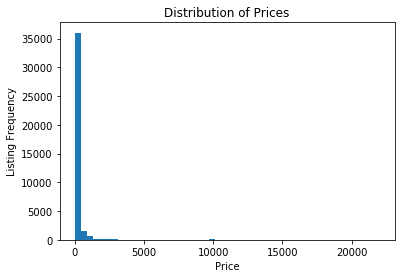

In [61]:
plt.hist(df.price,bins=50)
plt.xlabel("Price")
plt.ylabel("Listing Frequency")
plt.title("Distribution of Prices")
plt.show()

In [62]:
len(df[df.price>=2500])/len(df)


0.009678498803057994

Because the amount of listings above $5000/night is less than 1% of the entire dataset, 
it may be best to inspect the distribution for listings below that price. This gives us a better view of what's going on with the distribution of prices:

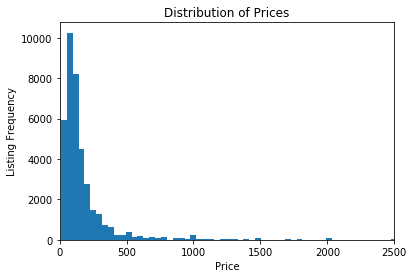

In [63]:
plt.hist(df.price, bins=500)
plt.xlim(right=2500)
plt.xlim(left=0)
plt.xlabel("Price")
plt.ylabel("Listing Frequency")
plt.title("Distribution of Prices")
plt.show()

Here we see that the majority of the distribution lies between 0-500/night, while there is a tail of listings with prices above $500/night.

In [64]:
print('The median price is '+ str(df.price.median())+' and the mean price is '+ str(df.price.mean()))

The median price is 110.0 and the mean price is 226.88128394553272


In [65]:
len(df[df.price>500])/len(df)

0.05812247419495997

And we see that only 5.8% of the listings are above $500/night.

In [66]:
#more descriptive stats?

##### Question: how have prices changed over time?



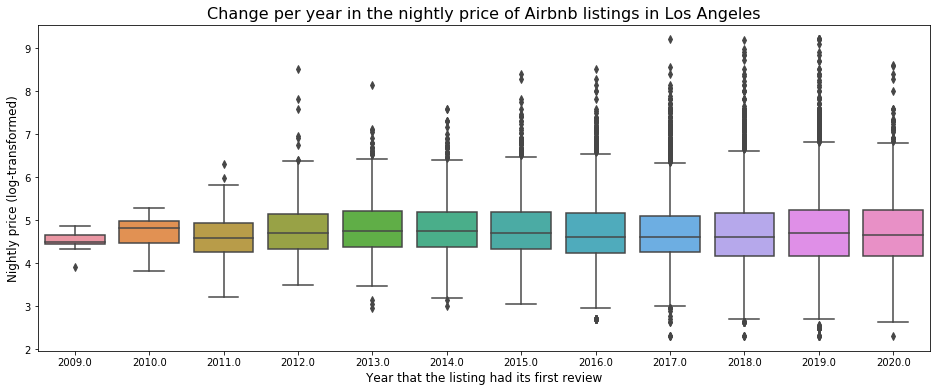

In [67]:
df.first_review = pd.to_datetime(df.first_review) # Converting to datetime
# number of days between the first review and the date the data was taken from AirBnB
#df['time_since_first_review'] = (datetime(2019, 4, 9) - df.first_review).astype('timedelta64[D]')

#found this type of plot in an example online, and thought it helped see 
plt.figure(figsize=(16,6))
sns.boxplot(df.first_review.dt.year, np.log(df.price))
plt.xlabel('Year that the listing had its first review', fontsize=12)
plt.ylabel('Nightly price (log-transformed)', fontsize=12)
plt.title('Change per year in the nightly price of Airbnb listings in Los Angeles', fontsize=16)
plt.show()

This is a place where I think it would be interesting to compare these time-series plots among different cities to see if there are differences in how the prices changed over time relating to other events happening around that time locally.

In [68]:
print("Mean nightly price of listings in each year on Airbnb in LA:")
print(round(df.set_index('first_review').price.resample('YS').mean(),2))

Mean nightly price of listings in each year on Airbnb in LA:
first_review
2009-01-01     93.11
2010-01-01    118.73
2011-01-01    122.68
2012-01-01    176.51
2013-01-01    176.62
2014-01-01    161.75
2015-01-01    164.66
2016-01-01    161.53
2017-01-01    163.79
2018-01-01    169.95
2019-01-01    183.05
2020-01-01    180.77
Name: price, dtype: float64


While the median has only slightly increased over time as we can see on the graph above, because the maximum price has increased so drastically from when this data started being compiled, it has caused the mean to increase from 93 per night to 180 per night, almost doubling in just 11 years of data. This begs the question: when did AirBnB start introducing the "Luxury Retreat" listings in to the mix?

##### Question: what is the distribution of reviews like? Does the absence of reviews affect price significantly?



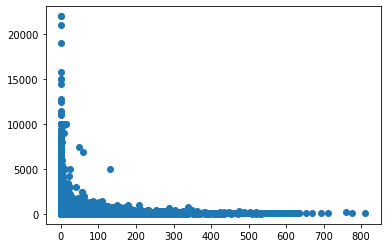

In [69]:
plt.scatter(df.number_of_reviews, df.price)

Less reviewed on higher priced listings -- makes sense

number of listings with reviews  31170
number of listings without reviews  7679
reviews, mean:  171.91607314725698 standard deviation:  325.2517772278992
no reviews, mean:  449.99179580674564 standard deviation:  1296.269874389097


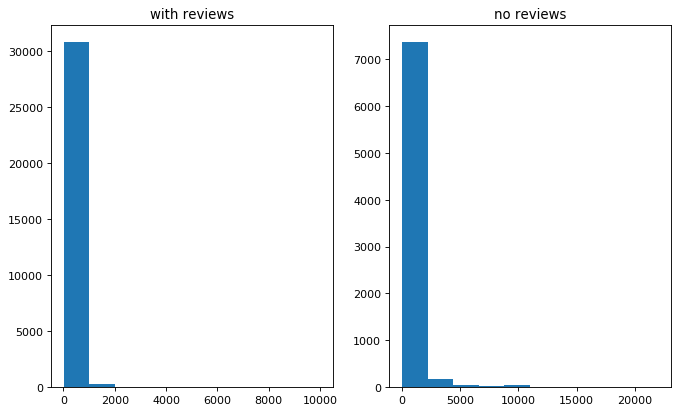

In [70]:
listings_reviews=df[df['number_of_reviews']>0]
listings_no_reviews=df[df['number_of_reviews']==0]
print('number of listings with reviews ',listings_reviews.shape[0])
print('number of listings without reviews ',listings_no_reviews.shape[0])
print('reviews, mean: ',np.mean(listings_reviews['price']),'standard deviation: ',np.std(listings_reviews['price']))
print('no reviews, mean: ',np.mean(listings_no_reviews['price']),'standard deviation: ',np.std(listings_no_reviews['price']))
plt.figure(figsize=(10, 6), dpi= 80, facecolor='w', edgecolor='k')
plt.subplot(1,2,1).set_title('with reviews')
plt.hist(listings_reviews['price'],bins=10);
plt.subplot(1,2,2).set_title('no reviews')
plt.hist(listings_no_reviews['price'],bins=10);
plt.show()

Looks like listings with no reviews have a higher sample mean in general. We can also infer that a listing with no reviews is either a newer listing or a very expensive listing that not many guests have booked because of price. Let's see if this is significant using bootstrapping:

98% confidence interval for the sample mean for listings with reviews [167.80608951 176.4131726 ]
98% confidence interval for the sample mean for listings without reviews [416.57193124 485.09778226]


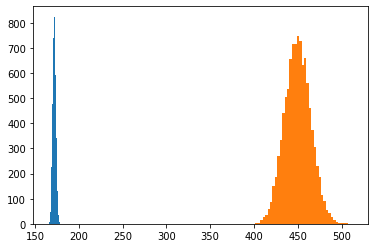

In [71]:
N=10000
n=listings_reviews.shape[0]
means=np.zeros(N)
for i in range(N):
    x=np.random.choice(listings_reviews['price'],n)
    means[i]=np.mean(x)
plt.hist(means,bins=40);
print("98% confidence interval for the sample mean for listings with reviews",np.percentile(means,[1,99]))

n=listings_no_reviews.shape[0]
means=np.zeros(N)
for i in range(N):
    x=np.random.choice(listings_no_reviews['price'],n)
    means[i]=np.mean(x)
plt.hist(means,bins=40);
print("98% confidence interval for the sample mean for listings without reviews",np.percentile(means,[1,99]))

##### Question: what are the most common property/room types?



(array([16790.,     0.,     0.,     0.,     0., 19417.,     0.,     0.,
            0.,  2642.]),
 array([0. , 0.2, 0.4, 0.6, 0.8, 1. , 1.2, 1.4, 1.6, 1.8, 2. ]),
 <a list of 10 Patch objects>)

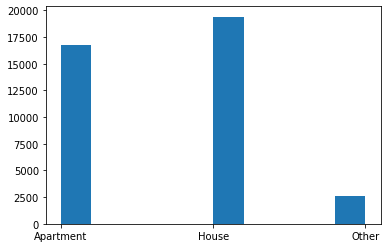

In [72]:
plt.hist(df.property_type)

(array([24355.,     0.,     0., 12808.,     0.,     0.,   215.,     0.,
            0.,  1471.]),
 array([0. , 0.3, 0.6, 0.9, 1.2, 1.5, 1.8, 2.1, 2.4, 2.7, 3. ]),
 <a list of 10 Patch objects>)

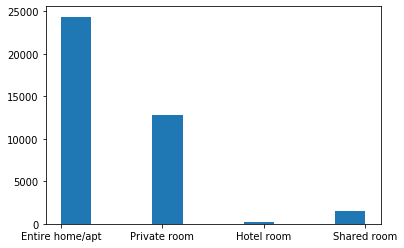

In [73]:
plt.hist(df.room_type)

##### Question: what is the distribution of the number of people accommodated an LA listing, and how does this affect price?



(array([2.2615e+04, 8.3630e+03, 4.2590e+03, 2.5630e+03, 4.4400e+02,
        1.9700e+02, 4.0300e+02, 2.0000e+00, 1.0000e+00, 2.0000e+00]),
 array([ 1. ,  3.3,  5.6,  7.9, 10.2, 12.5, 14.8, 17.1, 19.4, 21.7, 24. ]),
 <a list of 10 Patch objects>)

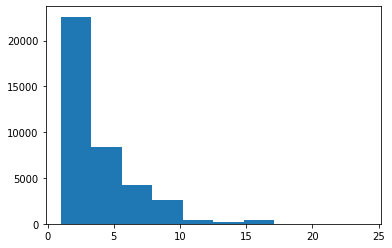

In [74]:
plt.hist(df.accommodates)

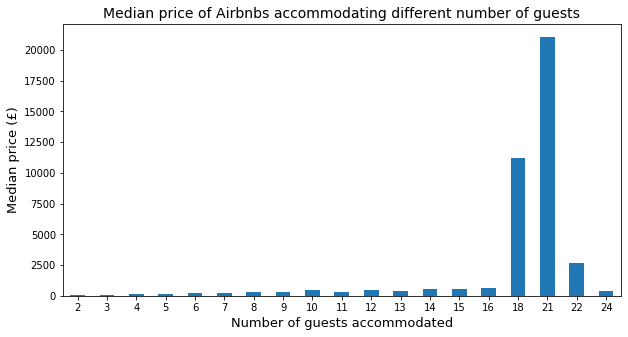

In [75]:
plt.figure(figsize=(10,5))
df.groupby('accommodates').price.median().plot(kind='bar')
plt.title('Median price of Airbnbs accommodating different number of guests', fontsize=14)
plt.xlabel('Number of guests accommodated', fontsize=13)
plt.ylabel('Median price (£)', fontsize=13)
plt.xticks(rotation=0)
plt.xlim(left=0.5)
plt.show()

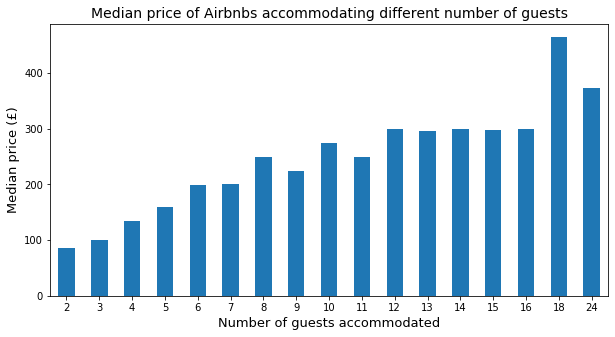

In [76]:
not_luxury = df[df.price<=500]
plt.figure(figsize=(10,5))
not_luxury.groupby('accommodates').price.median().plot(kind='bar')
plt.title('Median price of Airbnbs accommodating different number of guests', fontsize=14)
plt.xlabel('Number of guests accommodated', fontsize=13)
plt.ylabel('Median price (£)', fontsize=13)
plt.xticks(rotation=0)
plt.xlim(left=0.5)
plt.show()

##### Question: which areas of LA have the most Airbnb properties, and which are the most expensive?
GeoPandas

In [77]:
# Renaming the neighbourhood column
df.rename(columns={'neighbourhood_cleansed': 'borough'}, inplace=True)

# Importing the LA borough boundary GeoJSON file as a dataframe in geopandas
map_df = gpd.read_file('neighbourhoods_LA.geojson')
map_df.head()

/anaconda3/lib/python3.7/site-packages/pandas/core/frame.py:4133: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  errors=errors,


,neighbourhood,neighbourhood_group,geometry
0,Angeles Crest,Unincorporated Areas,"MULTIPOLYGON (((-118.09667 34.47348, -118.0796..."
1,Acton,Unincorporated Areas,"MULTIPOLYGON (((-118.20703 34.53902, -118.1894..."
2,Agua Dulce,Unincorporated Areas,"MULTIPOLYGON (((-118.37822 34.48811, -118.3783..."
3,Athens,Unincorporated Areas,"MULTIPOLYGON (((-118.29152 33.93096, -118.2916..."
4,Alondra Park,Unincorporated Areas,"MULTIPOLYGON (((-118.32651 33.89757, -118.3264..."


In [78]:
# Dropping the empty column
map_df.drop('neighbourhood_group', axis=1, inplace=True)

# Creating a dataframe of listing counts and median price by borough
borough_df = pd.DataFrame(df.groupby('borough').size())
borough_df.rename(columns={0: 'number_of_listings'}, inplace=True)
borough_df['median_price'] = df.groupby('borough').price.median().values

# Joining the dataframes
borough_map_df = map_df.set_index('neighbourhood').join(borough_df)

This map reveals that the areas with the most listings are near Long Beach, Anaheim, Santa Monica, and Hollywood. Three high-traffic areas for tourists in LA, and we see that the largest concentration of listings is in an area including both Long Beach Airport and DISNEYLAND. 

/anaconda3/lib/python3.7/site-packages/matplotlib/colors.py:527: RuntimeWarning: invalid value encountered in less
  xa[xa < 0] = -1


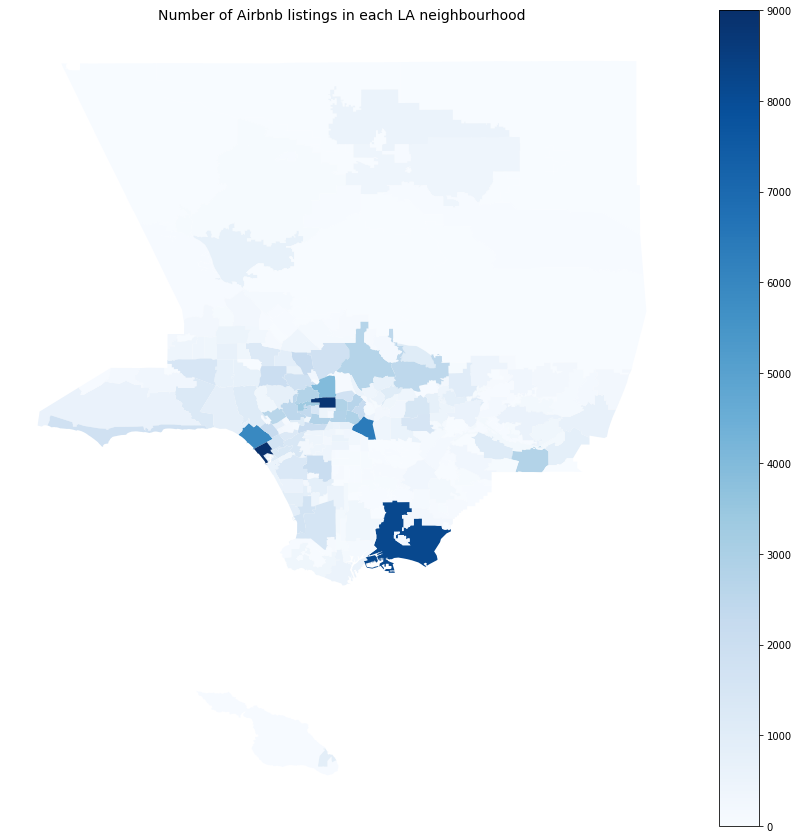

In [79]:
# Plotting the number of listings in each borough
fig1, ax1 = plt.subplots(1, figsize=(15, 15))
borough_map_df.plot(column='number_of_listings', cmap='Blues', ax=ax1)
ax1.axis('off')
ax1.set_title('Number of Airbnb listings in each LA neighbourhood', fontsize=14)
sm = plt.cm.ScalarMappable(cmap='Blues', norm=plt.Normalize(vmin=0, vmax=9000))
sm._A = [] # Creates an empty array for the data range
cbar = fig1.colorbar(sm)
plt.show()



Plotting the Median price reveals expected results with Malibu and Beverly Hills area as the most expensive listings. If we were interested in seeing more gradient here, we could plot a subset removing the luxury listings.

/anaconda3/lib/python3.7/site-packages/matplotlib/colors.py:527: RuntimeWarning: invalid value encountered in less
  xa[xa < 0] = -1


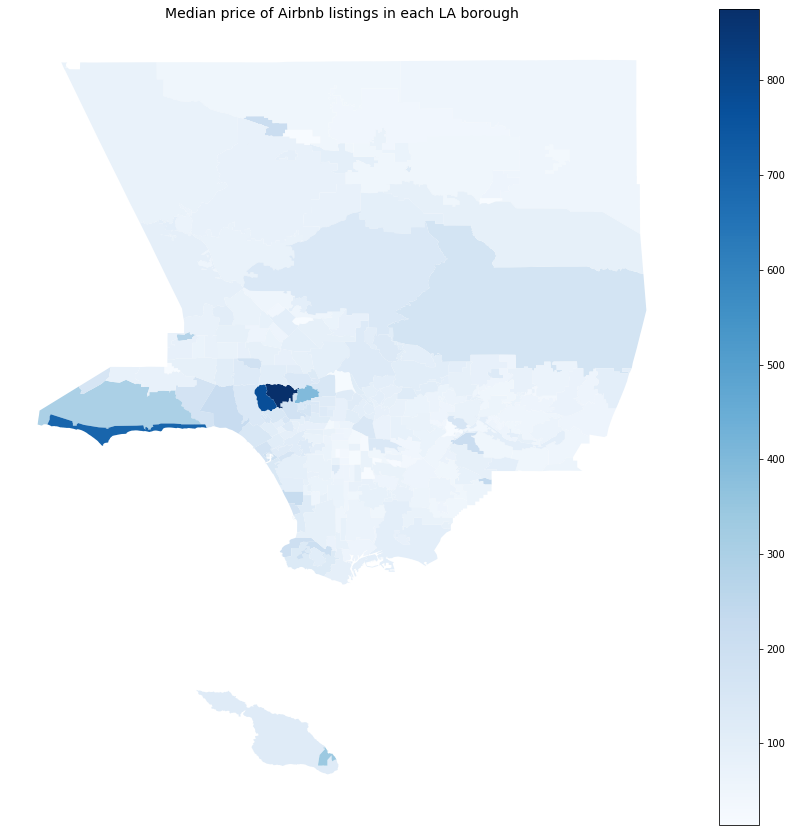

In [80]:
# Plotting the median price of listings in each borough
fig2, ax2 = plt.subplots(1, figsize=(15, 15))
borough_map_df.plot(column='median_price', cmap='Blues', ax=ax2)
ax2.axis('off')
ax2.set_title('Median price of Airbnb listings in each LA borough', fontsize=14)
sm = plt.cm.ScalarMappable(cmap='Blues', norm=plt.Normalize(vmin=min(borough_map_df.median_price), vmax=max(borough_map_df.median_price)))
sm._A = [] # Creates an empty array for the data range
cbar = fig2.colorbar(sm)
plt.show()

I'd like to investigate what this looks like without the luxury listings as I suspect that's what is skewing this so much. There is 98% confidence that the listings with reviews are $239 less than listings with no reviews.

# Get Ready to Model!

In [82]:
df.drop('first_review', axis=1, inplace=True)

In [83]:

transformed_df = pd.get_dummies(df)

In [84]:
def multi_collinearity_heatmap(df, figsize=(11,9)):
    
    """
    Creates a heatmap of correlations between features in the df. A figure size can optionally be set.
    """
    
    # Set the style of the visualization
    sns.set(style="white")

    # Create a covariance matrix
    corr = df.corr()

    # Generate a mask the size of our covariance matrix
    mask = np.zeros_like(corr, dtype=np.bool)
    mask[np.triu_indices_from(mask)] = True

    # Set up the matplotlib figure
    f, ax = plt.subplots(figsize=figsize)

    # Generate a custom diverging colormap
    cmap = sns.diverging_palette(220, 10, as_cmap=True)

    # Draw the heatmap with the mask and correct aspect ratio
    sns.heatmap(corr, mask=mask, cmap=cmap, center=0, square=True, linewidths=.5, cbar_kws={"shrink": .5}, vmax=corr[corr != 1.0].max().max());

There aren't significant collinear relationships between neighborhoods, so I'm going to look at collinearity between other attributes.

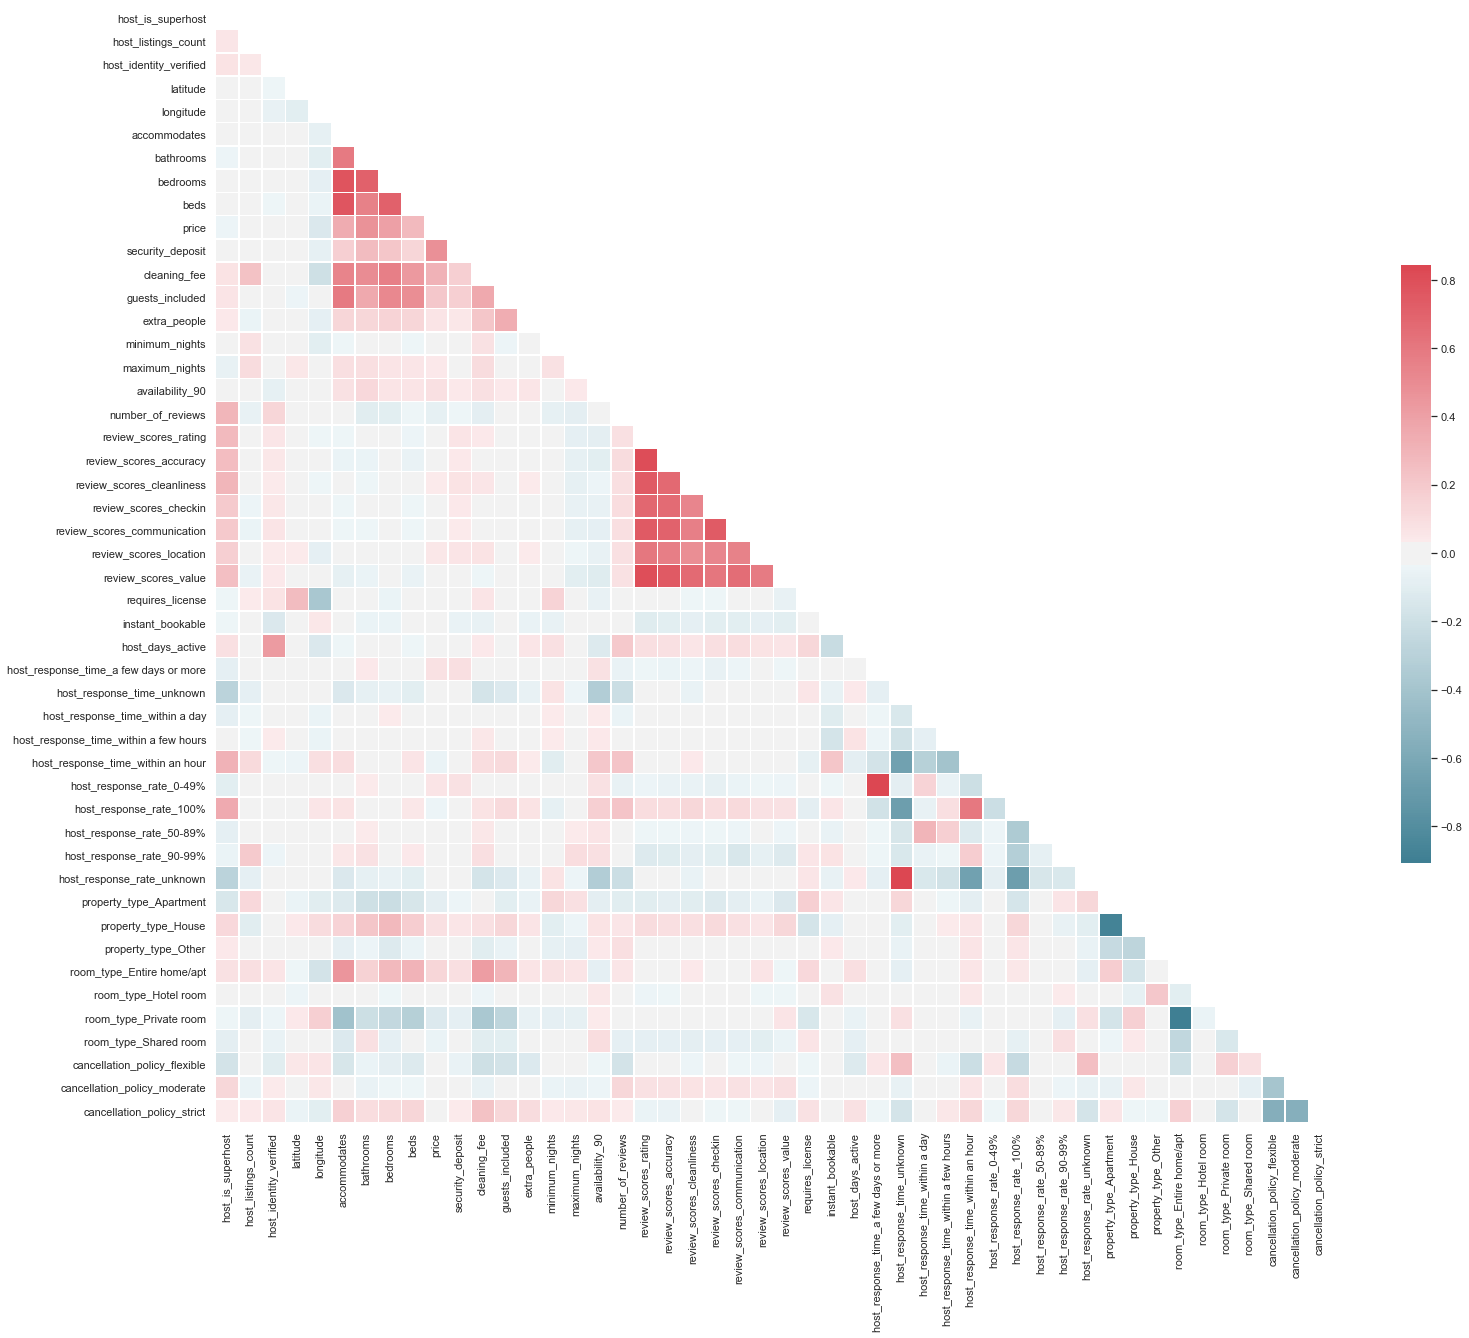

In [85]:
multi_collinearity_heatmap(transformed_df.drop(list(transformed_df.columns[transformed_df.columns.str.startswith('borough')]), axis=1), figsize=(25,22))

Areas of collinearity:

Property info (beds, bedrooms, bathrooms, accommodates) are highly correlated with each other, which makes sense.

Strong negative correlation between Private room and Entire Home/Apt, Apt and House, this makes sense because they were the two main categories for their attributes. One of each pair will be dropped (apt and private room because slightly less common) but can go back and try the model with them included to see how much the results change...

The unknown host_response_time and host_response_rate (one of these will be dropped)

Reviews are all correlated with each other, but instead of getting rid of all of them, there are probably subsets I can dig into better to see where the correlations are happening.

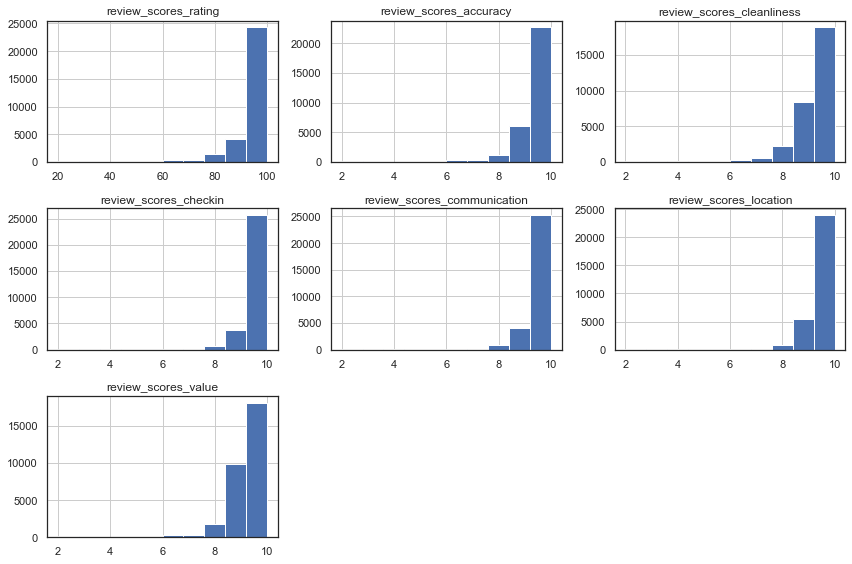

In [86]:
# Checking the distributions of the review ratings columns
variables_to_plot = list(df.columns[df.columns.str.startswith("review_scores") == True])
fig = plt.figure(figsize=(12,8))
for i, var_name in enumerate(variables_to_plot):
    ax = fig.add_subplot(3,3,i+1)
    df[var_name].hist(bins=10,ax=ax)
    ax.set_title(var_name)
fig.tight_layout()
plt.show()

In [87]:
#Only want the ones scored out of 10
variables_to_plot.pop(0)

'review_scores_rating'

In [88]:
def bin_column(col, bins, labels, na_label='unknown'):
    """
    Takes in a column name, bin cut points and labels, replaces the original column with a
    binned version, and replaces nulls (with 'unknown' if unspecified).
    """
    df[col] = pd.cut(df[col], bins=bins, labels=labels, include_lowest=True)
    df[col] = df[col].astype('str')
    df[col].fillna(na_label, inplace=True)

# out of 10
for col in variables_to_plot:
    bin_column(col,
               bins=[0, 8, 9, 10],
               labels=['0-8/10', '9/10', '10/10'],
               na_label='no reviews')
    
#out of 100
bin_column('review_scores_rating',
           bins=[0, 80, 95, 100],
           labels=['0-79/100', '80-94/100', '95-100/100'],
           na_label='no reviews')

In [89]:
transformed_df = pd.get_dummies(df)

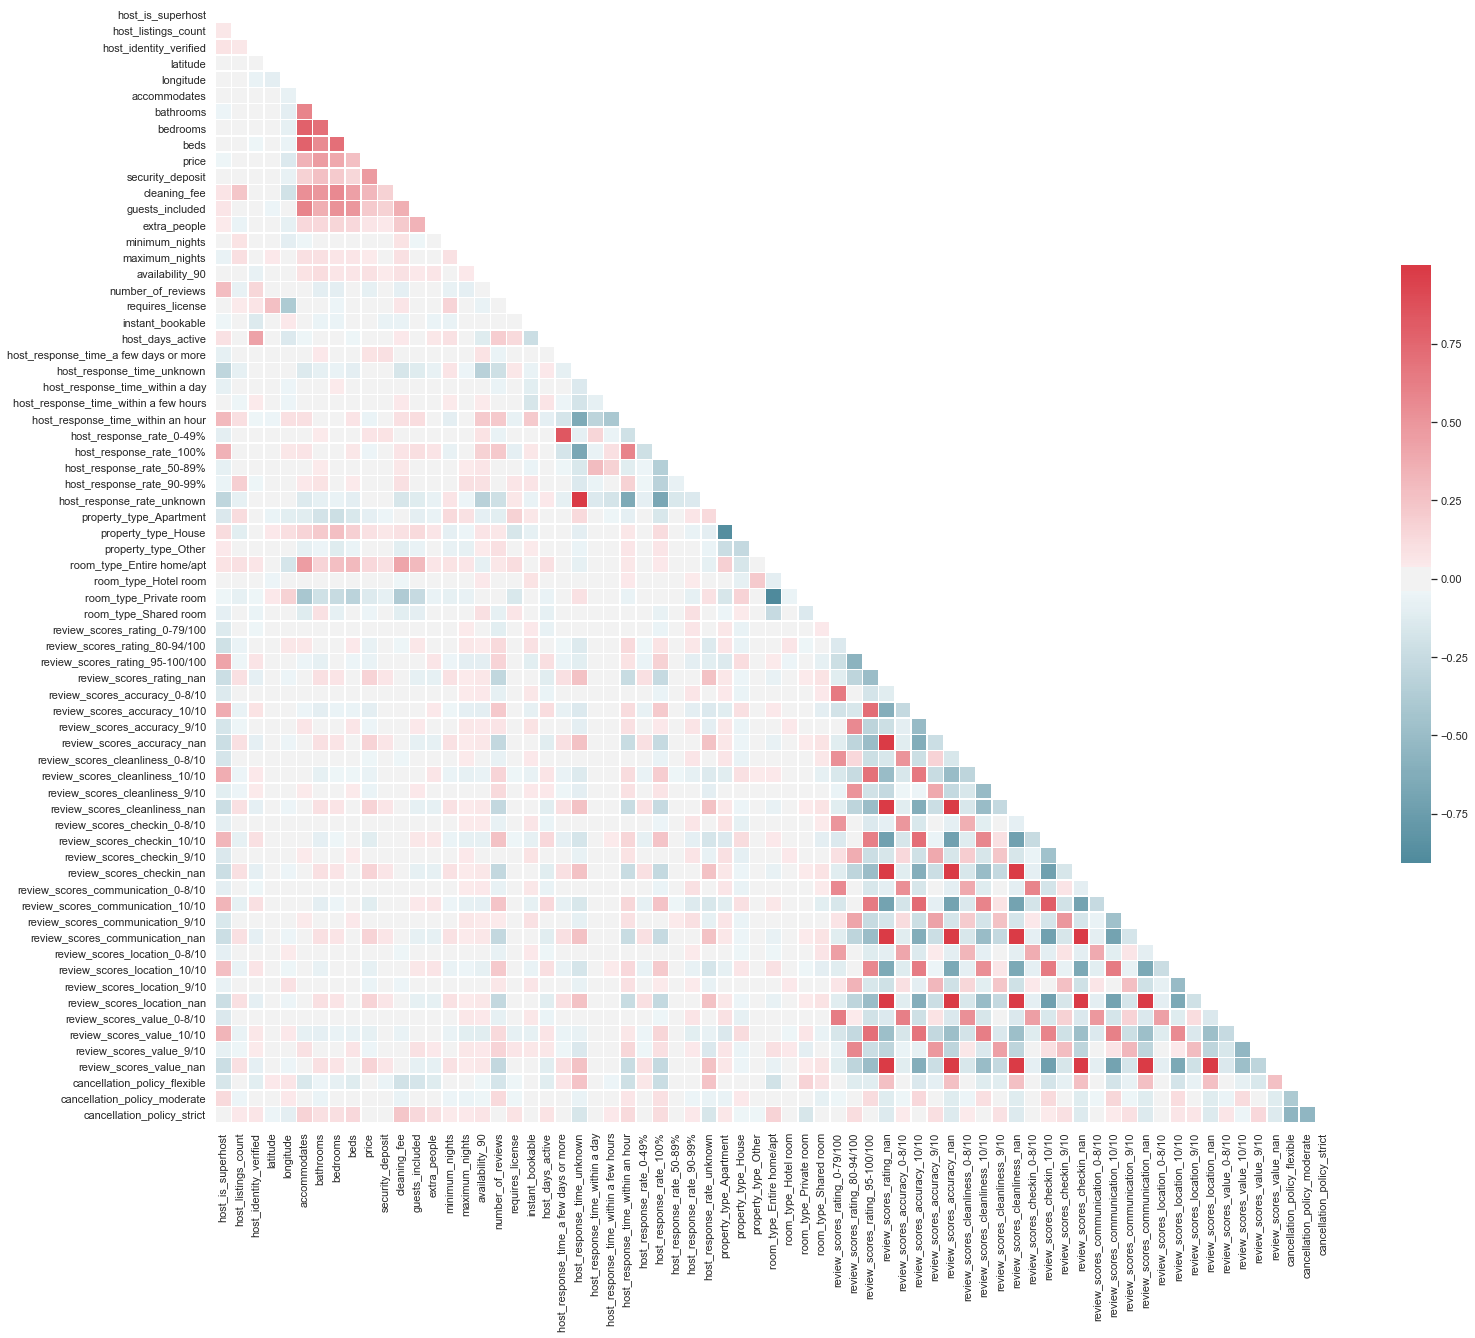

In [90]:
multi_collinearity_heatmap(transformed_df.drop(list(transformed_df.columns[transformed_df.columns.str.startswith('borough')]), axis=1), figsize=(25,22))

Now that the reviews are broken down, we can see that the highest correlations are between NaN review entries, so we can drop these.

In [91]:
#Dropping collinear attributes
to_drop = ['beds',
          'bedrooms',
          'guests_included',
          'host_response_rate_unknown',
          'host_response_rate_0-49%',
          'property_type_Apartment',
          'room_type_Private room',
            'review_scores_rating_nan',
           'review_scores_accuracy_nan',
           'review_scores_cleanliness_nan',
           'review_scores_checkin_nan',
           'review_scores_communication_nan',
           'review_scores_location_nan',
           'review_scores_value_nan'
          ]
transformed_df.drop(to_drop, axis=1, inplace=True)

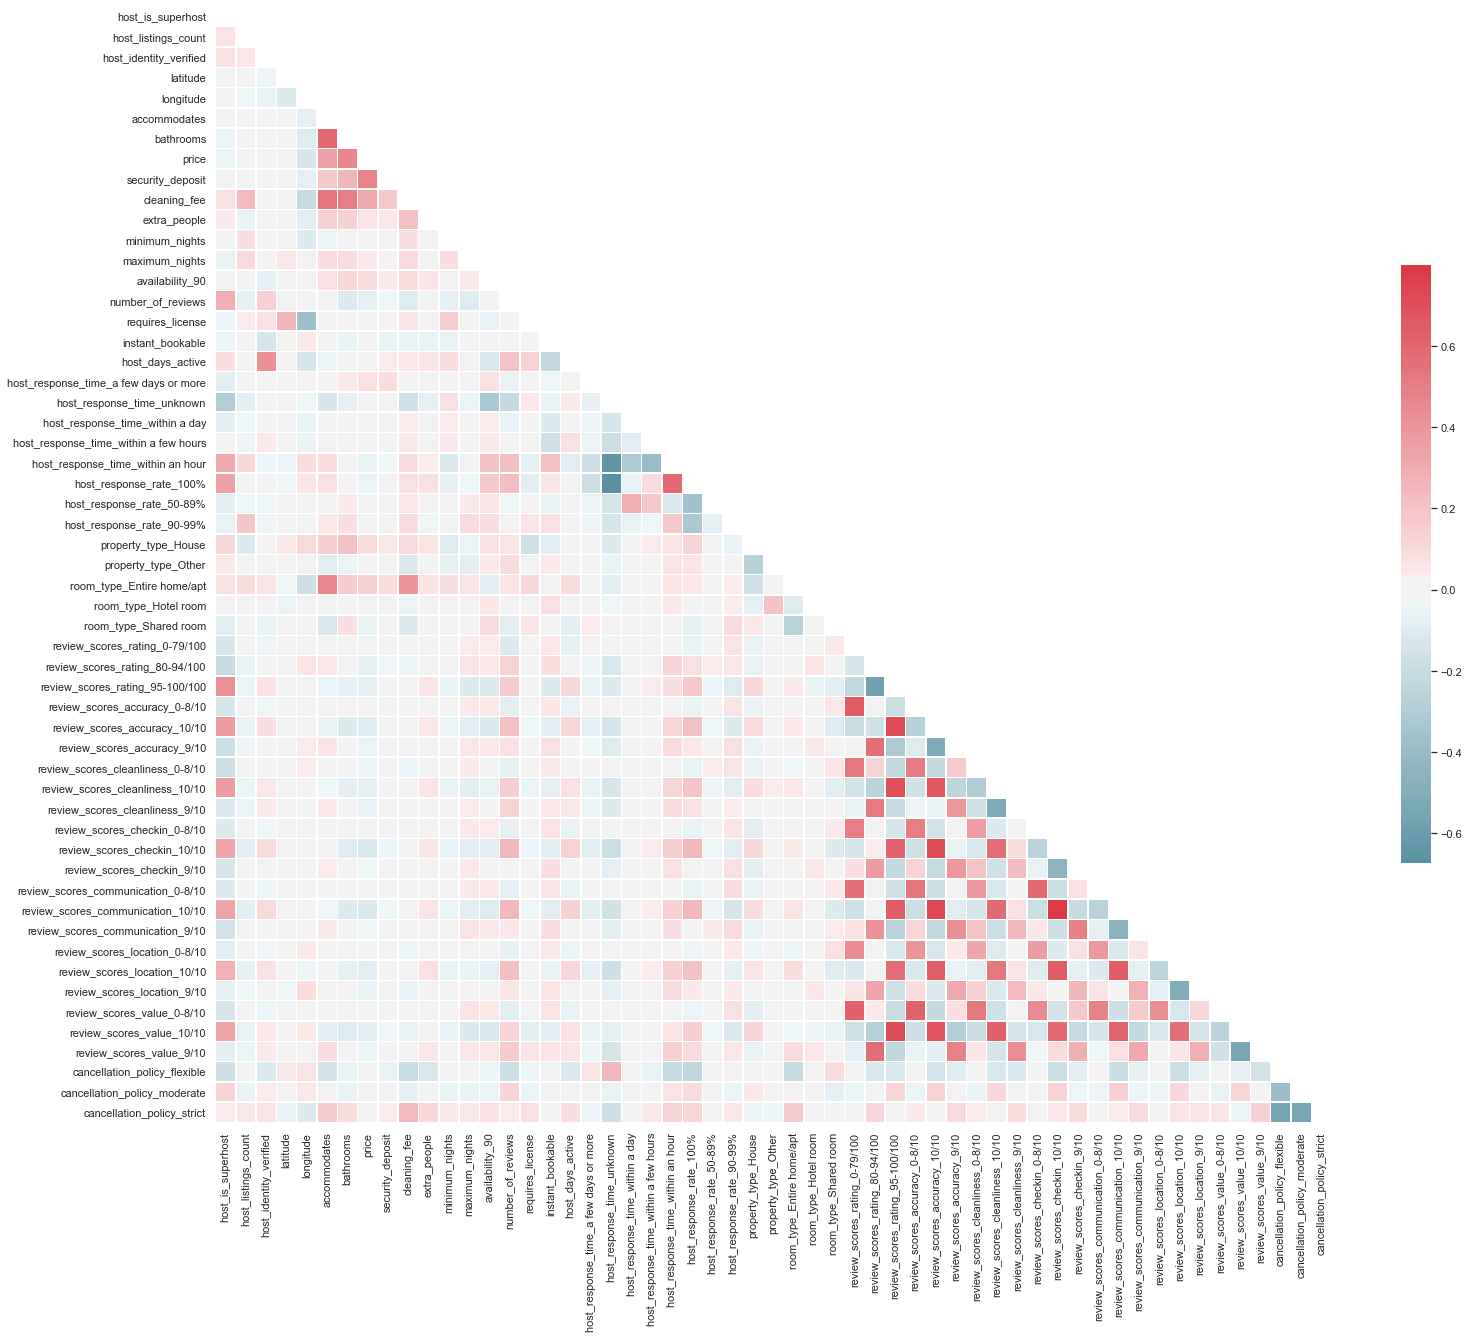

In [92]:
multi_collinearity_heatmap(transformed_df.drop(list(transformed_df.columns[transformed_df.columns.str.startswith('borough')]), axis=1), figsize=(25,22))

Still high correlation for highly rated reviews, but I will leave them for now.

In [93]:
numerical_columns = ['accommodates', 'availability_90', 'bathrooms', 'cleaning_fee', 'extra_people', 
                     'host_listings_count', 'maximum_nights', 'minimum_nights', 
                     'number_of_reviews', 'price', 'security_deposit']

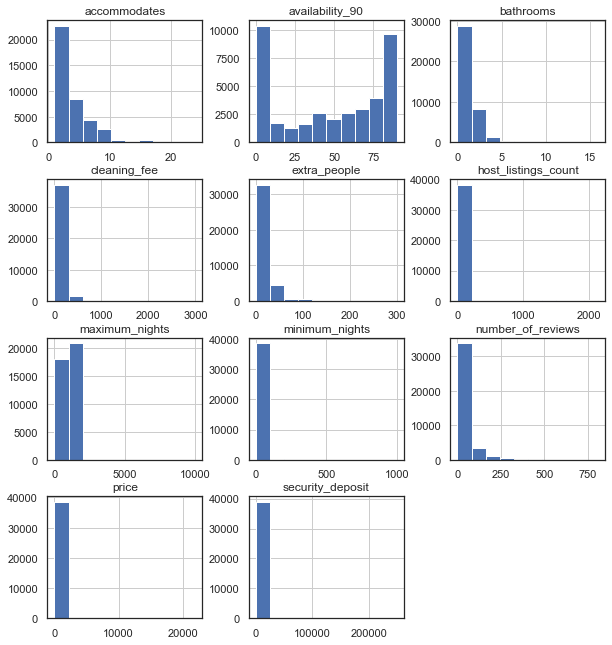

In [94]:
transformed_df[numerical_columns].hist(figsize=(10,11));

In [95]:
# Log transforming columns that are positively skewed
numerical_columns = [i for i in numerical_columns if i not in ['availability_90']] # Removing items not to be transformed

for col in numerical_columns:
    transformed_df[col] = transformed_df[col].astype('float64').replace(0.0, 0.01) # Replacing 0s with 0.01
    transformed_df[col] = np.log(transformed_df[col])

Helped some of the distributions but one important one in particular, price, now looks like a good normal distribution.

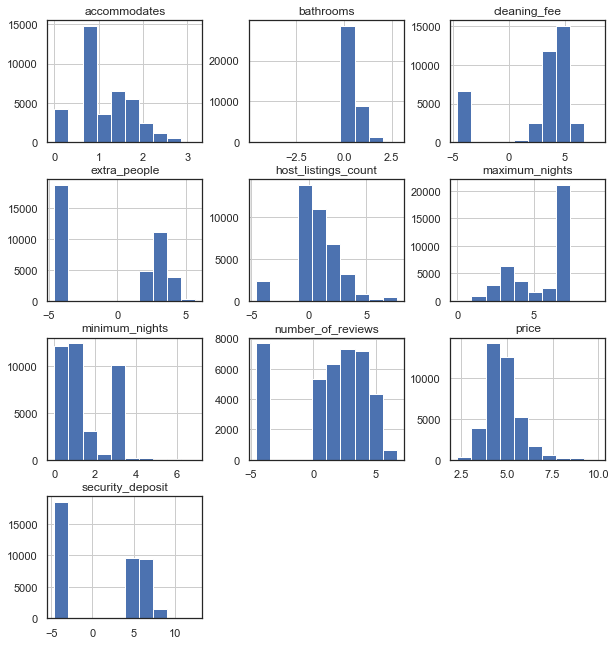

In [96]:
transformed_df[numerical_columns].hist(figsize=(10,11));

In [105]:
transformed_df.drop(['host_since'], axis=1, inplace=True)

In [106]:
# Separating X and y
X = transformed_df.drop('price', axis=1)
y = transformed_df.price


In [107]:
# Splitting into train and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=123)

# Random Forest Regression

In [109]:
from sklearn.ensemble import RandomForestRegressor

In [133]:
# Create the random forest model and fit to the training data
rfr = RandomForestRegressor(n_estimators=200)
rfr.fit(X_train, y_train)

#R^2 scores
print(rfr.score(X_train, y_train))
print(rfr.score(X_test, y_test))

0.9729553904553067
0.806592207483244


Would love to discuss this more with my mentor!

In [134]:
pd.set_option('display.max_rows', None)
ft_weights_rfr = pd.DataFrame(rfr.feature_importances_, columns=['weight'], index=X_train.columns)
ft_weights_rfr.sort_values('weight', inplace=True)
ft_weights_rfr

,weight
borough_Desert View Highlands,8.423249e-09
borough_Commerce,1.917019e-08
borough_East Compton,2.146066e-08
borough_Ridge Route,1.303720e-07
borough_South Diamond Bar,1.329167e-07
borough_Bradbury,1.403090e-07
borough_Lake Hughes,2.026226e-07
borough_Hawaiian Gardens,2.347497e-07
borough_Chatsworth Reservoir,3.112184e-07
borough_Val Verde,3.311970e-07


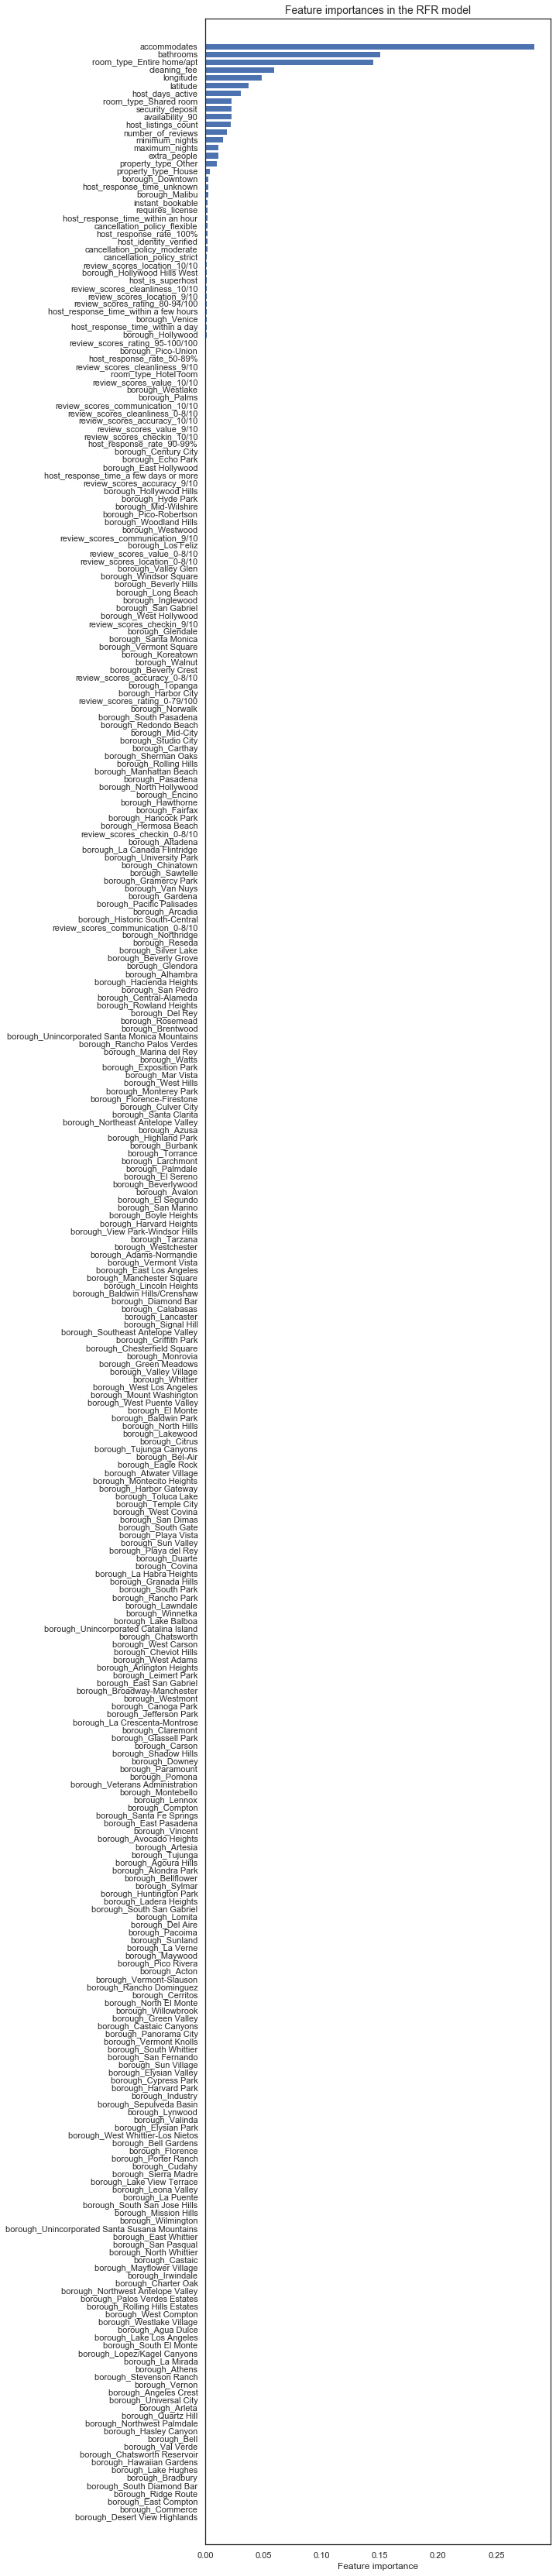

In [135]:
# Plotting feature importances
plt.figure(figsize=(8,60))
plt.barh(ft_weights_rfr.index, ft_weights_rfr.weight, align='center') 
plt.title("Feature importances in the RFR model", fontsize=14)
plt.xlabel("Feature importance")
plt.margins(y=0.01)
plt.show()

# Gradient Boosting

In [129]:
xgb_reg_start = time.time()

xgb_reg = xgb.XGBRegressor(objective='reg:squarederror', n_estimators = 200)
xgb_reg.fit(X_train, y_train)
training_preds_xgb_reg = xgb_reg.predict(X_train)
val_preds_xgb_reg = xgb_reg.predict(X_test)

xgb_reg_end = time.time()

print(f"Time taken to run: {round((xgb_reg_end - xgb_reg_start)/60,1)} minutes")
print("\nTraining MSE:", round(mean_squared_error(y_train, training_preds_xgb_reg),4))
print("Validation MSE:", round(mean_squared_error(y_test, val_preds_xgb_reg),4))
print("\nTraining r2:", round(r2_score(y_train, training_preds_xgb_reg),4))
print("Validation r2:", round(r2_score(y_test, val_preds_xgb_reg),4))

Time taken to run: 1.7 minutes

Training MSE: 0.1632
Validation MSE: 0.1772

Training r2: 0.7924
Validation r2: 0.782


In [130]:
pd.set_option('display.max_rows', None)
ft_weights_xgb_reg = pd.DataFrame(xgb_reg.feature_importances_, columns=['weight'], index=X_train.columns)
ft_weights_xgb_reg.sort_values('weight', inplace=True)
ft_weights_xgb_reg

,weight
borough_Valinda,0.000000
borough_Lennox,0.000000
borough_Leona Valley,0.000000
borough_Lincoln Heights,0.000000
borough_Lomita,0.000000
borough_Long Beach,0.000000
borough_Lopez/Kagel Canyons,0.000000
cancellation_policy_moderate,0.000000
borough_Lynwood,0.000000
borough_West Carson,0.000000


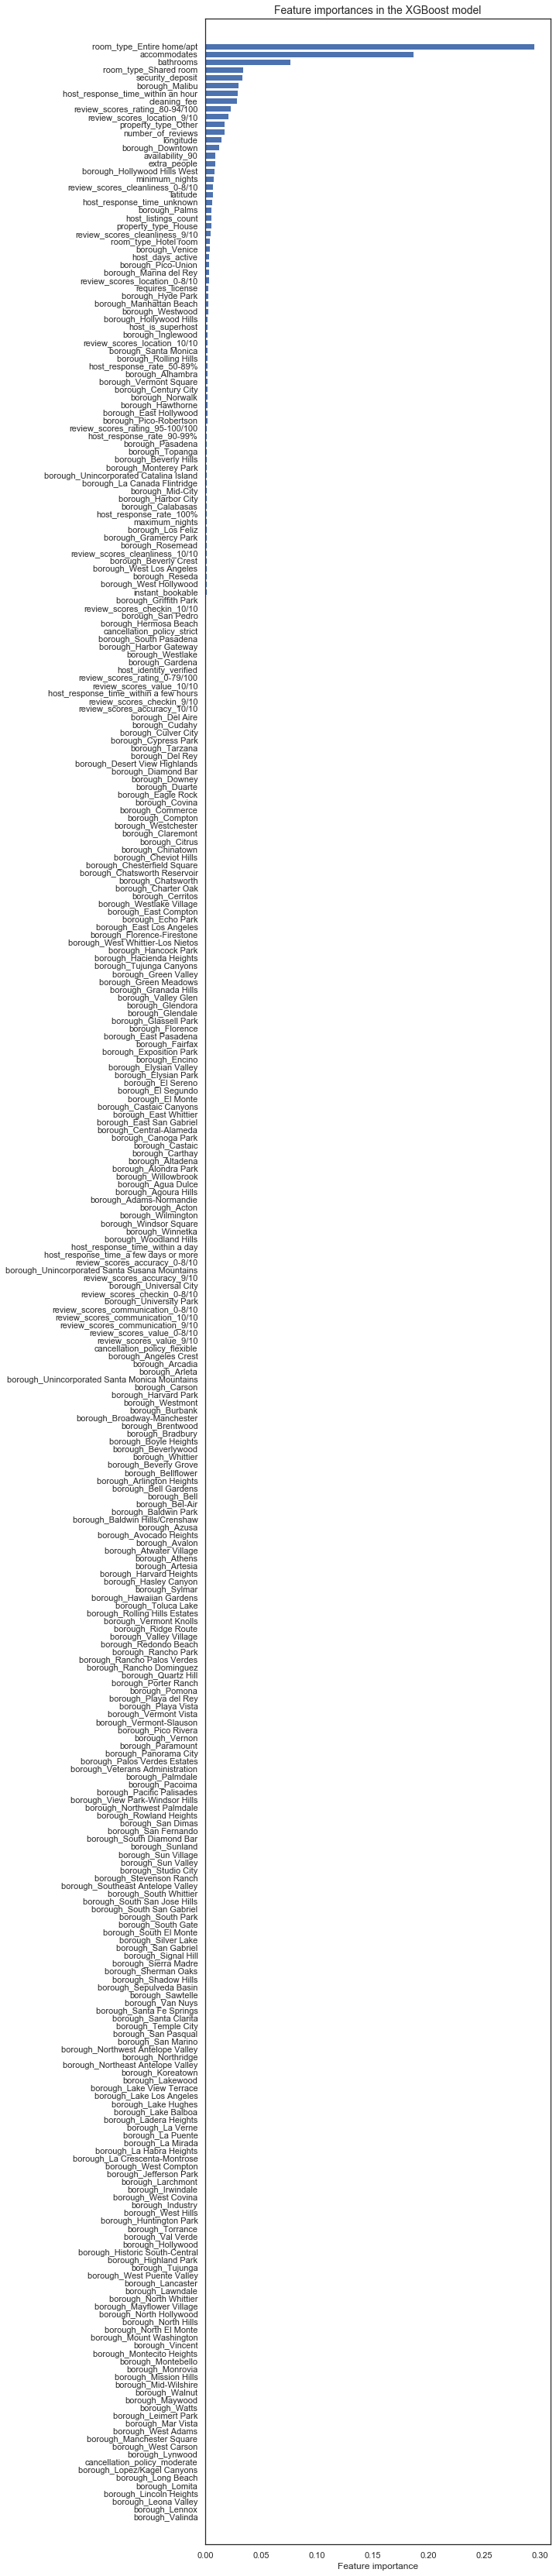

In [131]:
# Plotting feature importances
plt.figure(figsize=(8,60))
plt.barh(ft_weights_xgb_reg.index, ft_weights_xgb_reg.weight, align='center') 
plt.title("Feature importances in the XGBoost model", fontsize=14)
plt.xlabel("Feature importance")
plt.margins(y=0.01)
plt.show()